### This notebook generate the line benefits from the operational cost

In [785]:
# libraries
import os
import time
import math
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
# from kneed import KneeLocator
from pyomo.environ      import *
from pyomo.opt          import SolverFactory

In [786]:
#%% Defining the clustering functions
def KMeansMethod(OptClusters, Y_sklearn, _path_0, _path_1, CaseName_0, CaseName_1, table, data):
    # Running the K-means with the optimal number of clusters. Setting up the initializer and random state.
    kmeans_pca = KMeans(n_clusters=OptClusters, init='k-means++', random_state=42)
    kmeans_pca.fit(Y_sklearn)
    df_segm_pca_kmeans = pd.concat([table.reset_index(drop=True), pd.DataFrame(Y_sklearn)], axis=1)
    df_segm_pca_kmeans.columns.values[-3:] = ['Component 1', 'Component 2', 'Component 3']
    df_segm_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_
    # Saving the cluster on the NetworkCommitment CSV file
    df_segm_pca_kmeans.to_csv(_path_0 + '/oT_Result_NetworkCommitment_ReducedCost_Clusters_kmeans_' + CaseName_0 + '.csv', sep=',')
    # Storing clusters in the first table
    table['Segment K-means PCA'] = kmeans_pca.labels_
    table = table.reset_index()
    table = table.set_index(['Scenario', 'Period', 'Day', 'Month', 'Segment K-means PCA'])
    # Stacking the table to also have the lines as index
    df = table.stack()
    df = df.reset_index()
    # Adding a new column with the cluster for each LoadLevel
    data['Segment K-means PCA'] = np.where(data['Variable'] == df['Variable'],
                                                    df['Segment K-means PCA'], df['Segment K-means PCA'])
    # Adding the duration to each LoadLevel
    data['Duration'] = 1
    # Renaming the cluster with respective name adopting in openTEPES project
    data['Stage'] = data['Segment K-means PCA'].map({0: 'st1', 1: 'st2', 2: 'st3', 3: 'st4', 4: 'st5',
                                                                       5: 'st6', 6: 'st7', 7: 'st8', 8: 'st9',
                                                                       9: 'st10',
                                                                       10: 'st11', 11: 'st12', 12: 'st13', 13: 'st14',
                                                                       14: 'st15',
                                                                       15: 'st16', 16: 'st17', 17: 'st18', 18: 'st19',
                                                                       19: 'st20',
                                                                       20: 'st21', 21: 'st22', 22: 'st23', 23: 'st24',
                                                                       24: 'st25',
                                                                       25: 'st26', 26: 'st27', 27: 'st28', 28: 'st29',
                                                                       29: 'st30',
                                                                       30: 'st31', 31: 'st32', 32: 'st33', 33: 'st34',
                                                                       34: 'st35',
                                                                       35: 'st36', 36: 'st37', 37: 'st38', 38: 'st39',
                                                                       39: 'st40',
                                                                       40: 'st41', 41: 'st42', 42: 'st43', 43: 'st44',
                                                                       44: 'st45',
                                                                       45: 'st46', 46: 'st47', 47: 'st48', 48: 'st49',
                                                                       49: 'st50'})
    # Getting only the relevant information to build the new CSV file in CaseName_ByStages
    data = data[
        ['Scenario', 'Period', 'LoadLevel', 'Stage', 'InitialNode', 'FinalNode', 'Circuit', 'Value']]
    data.to_csv(_path_0 + '/oT_Test_ReducedCost_Clusters_' + CaseName_0 + '.csv', sep=',')
    # Shaping the dataframe to be saved in CSV files
    TableToFile = pd.pivot_table(data, values='Value', index=['LoadLevel', 'Stage', 'Duration'],
                                 columns=['InitialNode', 'FinalNode', 'Circuit'], fill_value=0)
    TableToFile = TableToFile.reset_index()
    # TableToFile['Duration'] = 1
    # Creating the dataframe to generate oT_Data_Duration
    dfDuration = pd.DataFrame(0, index=TableToFile.index, columns=['LoadLevel', 'Duration', 'Stage'])
    dfDuration['LoadLevel'] = TableToFile['LoadLevel']
    dfDuration['Duration'] = TableToFile['Duration']
    dfDuration['Stage'] = TableToFile['Stage']
    dfDuration.to_csv(_path_1 + '/oT_Data_Duration_' + CaseName_1 + '.csv', sep=',', index=False)
    # Identifying the Stages
    Stages = dfDuration.Stage.unique()
    Stages = np.sort(Stages)
    # Creating the dataframe to generate oT_Data_Stages
    dfa = pd.DataFrame({'Weight': dfDuration['Stage']})
    dfa = dfa['Weight'].value_counts()
    dfa = dfa / 24
    dfa = dfa.sort_index()
    dfStages = pd.DataFrame(dfa.values, index=dfa.index, columns=['Weight'])
    dfStages.to_csv(_path_1 + '/oT_Data_Stage_' + CaseName_1 + '.csv', sep=',')
    # Creating the dataframe to generate oT_Dict_Stages
    dict_Stages = pd.DataFrame(Stages, columns=['Stage'])
    dict_Stages.to_csv(_path_1 + '/oT_Dict_Stage_' + CaseName_1 + '.csv', sep=',', index=False)


def KMedoidsMethod(OptClusters, Y_sklearn, _path_0, _path_1, CaseName_0, CaseName_1, table, data):
    # Running the K-means with the optimal number of clusters. Setting up the initializer and random state.
    kmedoids_pca = KMedoids(metric="euclidean", n_clusters=OptClusters, init="heuristic", max_iter=2, random_state=42)
    kmedoids_pca.fit(Y_sklearn)
    df_segm_pca_kmedoids = pd.concat([table.reset_index(drop=True), pd.DataFrame(Y_sklearn)], axis=1)
    df_segm_pca_kmedoids.columns.values[-3:] = ['Component 1', 'Component 2', 'Component 3']
    df_segm_pca_kmedoids['Segment K-medoids PCA'] = kmedoids_pca.labels_
    # Saving the cluster on the NetworkCommitment CSV file
    df_segm_pca_kmedoids.to_csv(_path_0 + '/oT_Result_NetworkCommitment_ReducedCost_Clusters_kmedoids_' + CaseName_0 + '.csv', sep=',')
    # Storing clusters in the first table
    table['Segment K-medoids PCA'] = kmedoids_pca.labels_
    table = table.reset_index()
    table = table.set_index(['Day', 'Month', 'Segment K-medoids PCA'])
    # Stacking the table to also have the lines as index
    df = table.stack()
    df = df.reset_index()
    # Adding a new column with the cluster for each LoadLevel
    data['Segment K-medoids PCA'] = np.where(data['Variable'] == df['Variable'], df['Segment K-medoids PCA'], df['Segment K-medoids PCA'])
    # Adding the duration to each LoadLevel
    data['Duration'] = 0
    # Renaming the cluster with respective name adopting in openTEPES project
    data['Stage'] = data['Segment K-medoids PCA'].map({0: 'st1', 1: 'st2', 2: 'st3', 3: 'st4', 4: 'st5',
                                                                         5: 'st6', 6: 'st7', 7: 'st8', 8: 'st9', 9: 'st10',
                                                                         10: 'st11', 11: 'st12', 12: 'st13', 13: 'st14', 14: 'st15',
                                                                         15: 'st16', 16: 'st17', 17: 'st18', 18: 'st19', 19: 'st20',
                                                                         20: 'st21', 21: 'st22', 22: 'st23', 23: 'st24', 24: 'st25',
                                                                         25: 'st26', 26: 'st27', 27: 'st28', 28: 'st29', 29: 'st30',
                                                                         30: 'st31', 31: 'st32', 32: 'st33', 33: 'st34', 34: 'st35',
                                                                         35: 'st36', 36: 'st37', 37: 'st38', 38: 'st39', 39: 'st40',
                                                                         40: 'st41', 41: 'st42', 42: 'st43', 43: 'st44', 44: 'st45',
                                                                         45: 'st46', 46: 'st47', 47: 'st48', 48: 'st49', 49: 'st50',
                                                                         50: 'st51', 51: 'st52', 52: 'st53', 53: 'st54', 54: 'st55',
                                                                         55: 'st56', 56: 'st57', 57: 'st58', 58: 'st59', 59: 'st60',
                                                                         60: 'st61', 61: 'st62', 62: 'st63', 63: 'st64', 64: 'st65',
                                                                         65: 'st66', 66: 'st67', 67: 'st68', 68: 'st69', 69: 'st70',
                                                                         70: 'st71', 71: 'st72', 72: 'st73', 73: 'st74', 74: 'st75',
                                                                         75: 'st76', 76: 'st77', 77: 'st78', 78: 'st79', 79: 'st80',
                                                                         80: 'st81', 81: 'st82', 82: 'st83', 83: 'st84', 84: 'st85',
                                                                         85: 'st86', 86: 'st87', 87: 'st88', 88: 'st89', 89: 'st90',
                                                                         90: 'st91', 91: 'st92', 92: 'st93', 93: 'st94', 94: 'st95',
                                                                         95: 'st96', 96: 'st97', 97: 'st98', 98: 'st99', 99: 'st100',
                                                                         100: 'st101', 101: 'st102', 102: 'st103', 103: 'st104', 104: 'st105',
                                                                         105: 'st106', 106: 'st107', 107: 'st108', 108: 'st109', 109: 'st110',
                                                                         110: 'st111', 111: 'st112', 112: 'st113', 113: 'st114', 114: 'st115',
                                                                         115: 'st116', 116: 'st117', 117: 'st118', 118: 'st119', 119: 'st120',
                                                                         120: 'st121', 121: 'st122', 122: 'st123', 123: 'st124', 124: 'st125',
                                                                         125: 'st126', 126: 'st127', 127: 'st128', 128: 'st129', 129: 'st130',
                                                                         130: 'st131', 131: 'st132', 132: 'st133', 133: 'st134', 134: 'st135',
                                                                         135: 'st136', 136: 'st137', 137: 'st138', 138: 'st139', 139: 'st140',
                                                                         140: 'st141', 141: 'st142', 142: 'st143', 143: 'st144', 144: 'st145',
                                                                         145: 'st146', 146: 'st147', 147: 'st148', 148: 'st149', 149: 'st150',
                                                                         150: 'st151', 151: 'st152', 152: 'st153', 153: 'st154', 154: 'st155',
                                                                         155: 'st156', 156: 'st157', 157: 'st158', 158: 'st159', 159: 'st160'})

    #
    idx = kmedoids_pca.medoid_indices_
    dfDayToStage = pd.DataFrame(idx, columns=['Day'])
    dfDayToStage = dfDayToStage + 1
    for k in dfDayToStage.index:
        data.loc[data['Day'] == dfDayToStage['Day'][k], 'Duration'] = 1

    # Getting only the relevant information to build the new CSV file in CaseName_ByStages
    # data = data[
        # ['Scenario', 'Period', 'LoadLevel', 'Stage', 'InitialNode', 'FinalNode', 'Circuit', 'Duration', 'Value']]
    data = data[
        ['LoadLevel', 'Stage', 'Execution', 'Duration', 'Value']]
    data.to_csv(_path_0 + '/oT_Test_ReducedCost_Clusters_' + CaseName_0 + '.csv', sep=',')
    # Shaping the dataframe to be saved in CSV files
    # TableToFile = pd.pivot_table(data, values='Value', index=['LoadLevel', 'Stage', 'Duration'],
    #                              columns=['InitialNode', 'FinalNode', 'Circuit'], fill_value=0)
    TableToFile = pd.pivot_table(data, values='Value', index=['LoadLevel', 'Stage', 'Duration'],
                                 columns=['Execution'], fill_value=0)
    TableToFile = TableToFile.reset_index()
    # Creating the dataframe to generate oT_Data_Duration
    dfDuration = pd.DataFrame(0, index=TableToFile.index, columns=['LoadLevel', 'Duration', 'Stage'])
    dfDuration['LoadLevel'] = TableToFile['LoadLevel']
    dfDuration['Duration'] = TableToFile['Duration']
    dfDuration['Stage'] = TableToFile['Stage']
    dfDuration.to_csv(os.path.join(_path_1, '2.Par', 'oT_Data_Duration_' + CaseName_1 + '.csv'), sep=',', index=False)
    # dfDuration.to_csv(_path_1 + '/oT_Data_Duration_' + CaseName_1 + '.csv', sep=',', index=False)
    # Identifying the Stages
    Stages = dfDuration.Stage.unique()
    Stages = np.sort(Stages)
    # Creating the dataframe to generate oT_Data_Stages
    dfa = pd.DataFrame({'Weight': dfDuration['Stage']})
    dfa = dfa['Weight'].value_counts()
    dfa = dfa/24
    dfa = dfa.sort_index()
    dfStages = pd.DataFrame(dfa.values, index=dfa.index, columns=['Weight'])
    dfStages.index.name = None
    dfStages.to_csv(os.path.join(_path_1, '2.Par', 'oT_Data_Stage_' + CaseName_1 + '.csv'), sep=',')
    # dfStages.to_csv(_path_1 + '/oT_Data_Stage_' + CaseName_1 + '.csv', sep=',')
    # Creating the dataframe to generate oT_Dict_Stages
    dict_Stages = pd.DataFrame(Stages, columns=['Stage'])
    dict_Stages.to_csv(os.path.join(_path_1, '1.Set', 'oT_Dict_Stage_' + CaseName_1 + '.csv'), sep=',', index=False)
    # dict_Stages.to_csv(_path_1 + '/oT_Dict_Stage_' + CaseName_1 + '.csv', sep=',', index=False)

    return kmedoids_pca

### Reading the data for clustering

In [787]:
#%% Setting up the path a cases
DirName  = os.getcwd()

opt_cluster = 100

CaseName_Base     = 'RTS24'
# CaseName_ByStages = CaseName_Base+'_ByStages'
CaseName_ByStages = CaseName_Base+'_ByStages_nc'+str(opt_cluster)

CSV_name =  'oT_Data_Profiles_' + CaseName_Base

_path_0 = os.path.join(DirName, CaseName_Base)
_path_1 = os.path.join(DirName, CaseName_ByStages)

StartTime = time.time()

#%% Selecting the maximum number of cluster to plot
max_cluster = 300
#%% Selecting the optimal number of cluster and defining the clustering method (0: k-means; 1:k-medoids)
# opt_cluster = 150
cluster_method = 1

output_directory = DirName + '/' + CaseName_ByStages + '/'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)


In [788]:
df_1 = pd.read_csv(_path_0+'/2.Par'+'/'+CSV_name+'.csv', index_col=0)
diff_df_1 = df_1

In [789]:
#%% Loading Sets from CSV
dictSets = DataPortal()
dictSets.load(filename=_path_0+'/1.Set'+'/oT_Dict_LoadLevel_'   +CaseName_Base+'.csv', set='n'   , format='set')

#### Line benefits

In [790]:
diff_df_1.head()

,Unnamed: 1,Unnamed: 2,Demand,Solar,Wind,Hydro
2030,sc01,01-01 00:00:00+01:00,1083.521771,0.02,2852.8,25.2
2030,sc01,01-01 01:00:00+01:00,1084.297378,0.02,2851.2,22.8
2030,sc01,01-01 02:00:00+01:00,1101.748516,0.02,2833.6,22.8
2030,sc01,01-01 03:00:00+01:00,1139.753216,0.02,2842.8,25.2
2030,sc01,01-01 04:00:00+01:00,1253.767318,0.02,2805.6,22.8


In [791]:
diff_df_1['LoadLevel'] = dictSets['n' ]
diff_df_1.set_index('LoadLevel', inplace=True)

In [792]:
diff_df_1.head()

,Unnamed: 1,Unnamed: 2,Demand,Solar,Wind,Hydro
LoadLevel,,,,,,
01-01 00:00:00+01:00,sc01,01-01 00:00:00+01:00,1083.521771,0.02,2852.8,25.2
01-01 01:00:00+01:00,sc01,01-01 01:00:00+01:00,1084.297378,0.02,2851.2,22.8
01-01 02:00:00+01:00,sc01,01-01 02:00:00+01:00,1101.748516,0.02,2833.6,22.8
01-01 03:00:00+01:00,sc01,01-01 03:00:00+01:00,1139.753216,0.02,2842.8,25.2
01-01 04:00:00+01:00,sc01,01-01 04:00:00+01:00,1253.767318,0.02,2805.6,22.8


In [793]:
# Selecting the columns demand, wind, solar, hydro
diff_df_1 = diff_df_1[['Demand', 'Wind', 'Solar', 'Hydro']]

In [794]:
ddf_1 = diff_df_1.stack()

In [795]:
ddf_1.index.names = ['LoadLevel', 'Execution']

In [796]:
# changing the column name
ddf_1 = ddf_1.to_frame(name='Value')

In [797]:
ddf_1.head()

Value
LoadLevel            Execution             
01-01 00:00:00+01:00 Demand     1083.521771
                     Wind       2852.800000
                     Solar         0.020000
                     Hydro        25.200000
01-01 01:00:00+01:00 Demand     1084.297378

In [798]:
ddf_1 = ddf_1.reset_index()

In [799]:
ddf_1['Date'] = ddf_1['LoadLevel']
ddf_1['Date'] = ddf_1['Date'].str.slice(0, -6)

In [800]:
# ddf_1['Date'] = pd.to_datetime(ddf_1['Date'], format='%Y-%m-%dT%H:%M:%S', errors='coerce')

In [801]:
ddf_1['Date'] = pd.to_datetime(ddf_1['Date'], format='%m-%d %H:%M:%S', errors='coerce')

In [802]:
ddf_1.tail()

,LoadLevel,Execution,Value,Date
34939,12-30 22:00:00+01:00,Hydro,96.00000,1900-12-30 22:00:00
34940,12-30 23:00:00+01:00,Demand,1090.89003,1900-12-30 23:00:00
34941,12-30 23:00:00+01:00,Wind,2687.20000,1900-12-30 23:00:00
34942,12-30 23:00:00+01:00,Solar,0.02000,1900-12-30 23:00:00
34943,12-30 23:00:00+01:00,Hydro,76.20000,1900-12-30 23:00:00


#### Getting day of year and month

In [803]:
ddf_1['Hour' ] = ddf_1['Date'].dt.hour
ddf_1['Day'  ] = ddf_1['Date'].dt.dayofyear
ddf_1['Week' ] = ddf_1['Date'].dt.isocalendar().week
ddf_1['Month'] = ddf_1['Date'].dt.month

In [804]:
ddf_1.head()

,LoadLevel,Execution,Value,Date,Hour,Day,Week,Month
0,01-01 00:00:00+01:00,Demand,1083.521771,1900-01-01 00:00:00,0,1,1,1
1,01-01 00:00:00+01:00,Wind,2852.800000,1900-01-01 00:00:00,0,1,1,1
2,01-01 00:00:00+01:00,Solar,0.020000,1900-01-01 00:00:00,0,1,1,1
3,01-01 00:00:00+01:00,Hydro,25.200000,1900-01-01 00:00:00,0,1,1,1
4,01-01 01:00:00+01:00,Demand,1084.297378,1900-01-01 01:00:00,1,1,1,1


#### Generation new ID considering each line, and hour

In [805]:
ddf_1['Variable'] = ddf_1['Execution'] + '_' + ddf_1['Hour'].astype(str)

In [806]:
ddf_1.tail()

,LoadLevel,Execution,Value,Date,Hour,Day,Week,Month,Variable
34939,12-30 22:00:00+01:00,Hydro,96.00000,1900-12-30 22:00:00,22,364,52,12,Hydro_22
34940,12-30 23:00:00+01:00,Demand,1090.89003,1900-12-30 23:00:00,23,364,52,12,Demand_23
34941,12-30 23:00:00+01:00,Wind,2687.20000,1900-12-30 23:00:00,23,364,52,12,Wind_23
34942,12-30 23:00:00+01:00,Solar,0.02000,1900-12-30 23:00:00,23,364,52,12,Solar_23
34943,12-30 23:00:00+01:00,Hydro,76.20000,1900-12-30 23:00:00,23,364,52,12,Hydro_23


In [807]:
table = pd.pivot_table(ddf_1, values='Value', index=['Month', 'Day'], columns=['Variable'], aggfunc=np.sum)

In [808]:
table.tail()

Variable      Demand_0     Demand_1    Demand_10    Demand_11    Demand_12  \
Month Day                                                                    
12    360  1264.238001  1254.930728  1478.693097  1444.954231  1416.256803   
      361  1282.076942  1270.830653  1350.330282  1279.362320  1219.252845   
      362  1211.108980  1197.535874  1266.177017  1207.230950  1171.553067   
      363  1175.818901  1170.777462  1189.779812  1135.099580  1087.399802   
      364  1104.463137  1108.728971  1255.318530  1204.904131  1163.797007   

Variable     Demand_13    Demand_14    Demand_15    Demand_16    Demand_17  \
Month Day                                                                    
12    360  1397.254453  1386.395967  1408.500742  1518.636813  1587.277956   
      361  1170.777462  1154.101929  1169.614052  1308.835354  1443.015215   
      362  1136.650792  1126.180109  1137.038595  1251.440500  1345.676646   
      363  1048.231692  1020.309871  1024.575705  1131.997155  1261.135577   
      364  1133.936170  1123.853291  1142.855640  1286.730579  1409.276349   

Variable   ...  Wind_21  Wind_22   Wind_23  Wind_3  Wind_4    Wind_5  \
Month Day  ...                                                         
12    360  ...    568.8    898.8  1490.400   951.2   630.0   808.400   
      361  ...   2750.8   2682.0  2700.400  2132.4  2434.8  2484.800   
      362  ...   2846.0   2665.6  1784.000  1141.6   792.8   435.600   
      363  ...     33.2      3.2     0.004  2645.6  2808.0  2817.200   
      364  ...   2622.8   2669.2  2687.200    20.4     7.6     0.004   

Variable     Wind_6    Wind_7  Wind_8  Wind_9  
Month Day                                      
12    360   201.200   284.400  1257.6  1079.2  
      361  2594.800  2698.400  2813.2  2841.2  
      362    95.200    21.600   391.6   875.2  
      363  2843.200  2848.000  2846.0  2831.2  
      364     0.004     0.004     1.6    22.8  

[5 rows x 96 columns]

In [809]:
table = table.reset_index()

In [810]:
table = table.set_index(['Day'])

In [811]:
table.tail()

Variable,Month,Demand_0,Demand_1,Demand_10,Demand_11,Demand_12,Demand_13,Demand_14,Demand_15,Demand_16,...,Wind_21,Wind_22,Wind_23,Wind_3,Wind_4,Wind_5,Wind_6,Wind_7,Wind_8,Wind_9
Day,,,,,,,,,,,,,,,,,,,,,
360,12,1264.238001,1254.930728,1478.693097,1444.954231,1416.256803,1397.254453,1386.395967,1408.500742,1518.636813,...,568.8,898.8,1490.400,951.2,630.0,808.400,201.200,284.400,1257.6,1079.2
361,12,1282.076942,1270.830653,1350.330282,1279.362320,1219.252845,1170.777462,1154.101929,1169.614052,1308.835354,...,2750.8,2682.0,2700.400,2132.4,2434.8,2484.800,2594.800,2698.400,2813.2,2841.2
362,12,1211.108980,1197.535874,1266.177017,1207.230950,1171.553067,1136.650792,1126.180109,1137.038595,1251.440500,...,2846.0,2665.6,1784.000,1141.6,792.8,435.600,95.200,21.600,391.6,875.2
363,12,1175.818901,1170.777462,1189.779812,1135.099580,1087.399802,1048.231692,1020.309871,1024.575705,1131.997155,...,33.2,3.2,0.004,2645.6,2808.0,2817.200,2843.200,2848.000,2846.0,2831.2
364,12,1104.463137,1108.728971,1255.318530,1204.904131,1163.797007,1133.936170,1123.853291,1142.855640,1286.730579,...,2622.8,2669.2,2687.200,20.4,7.6,0.004,0.004,0.004,1.6,22.8


#### Split data table into data X and class labels y

In [812]:
X = table.iloc[:,1:len(table.columns)+1].values
y = table.iloc[:,0].values

In [813]:
print(X)
print(y)

[[1.08352177e+03 1.08429738e+03 1.26850383e+03 ... 2.07080000e+03
  1.70640000e+03 1.09680000e+03]
 [1.06800965e+03 1.06529503e+03 1.24135762e+03 ... 2.75720000e+03
  2.73520000e+03 2.79440000e+03]
 [1.04357805e+03 1.02612692e+03 1.25299171e+03 ... 2.77760000e+03
  2.76040000e+03 2.76120000e+03]
 ...
 [1.21110898e+03 1.19753587e+03 1.26617702e+03 ... 2.16000000e+01
  3.91600000e+02 8.75200000e+02]
 [1.17581890e+03 1.17077746e+03 1.18977981e+03 ... 2.84800000e+03
  2.84600000e+03 2.83120000e+03]
 [1.10446314e+03 1.10872897e+03 1.25531853e+03 ... 4.00000000e-03
  1.60000000e+00 2.28000000e+01]]
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  5  5  5  5  5  5  5  5  5  5  5  

## PCA step by step

#### Standardizing of the data

In [814]:
X_std = StandardScaler().fit_transform(X)

#### Eigendecomposition of the raw data based on the correlation matrix:

In [815]:
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 0.13559696  0.14618037 -0.03576155 ...  0.          0.
   0.        ]
 [ 0.13167536  0.15241177 -0.04185736 ...  0.          0.
   0.        ]
 [ 0.14685226  0.11935687 -0.0148815  ...  0.          0.
   0.        ]
 ...
 [-0.10118812  0.12388745  0.1320797  ...  0.          0.
   0.        ]
 [-0.11612224  0.12413951  0.10904433 ...  0.          0.
   0.        ]
 [-0.11927833  0.12938764  0.10311826 ...  0.          0.
   0.        ]]

Eigenvalues 
[3.67898759e+01 1.15812231e+01 9.97209830e+00 6.36959113e+00
 3.54642958e+00 3.25904253e+00 2.35353341e+00 1.76317949e+00
 1.42635652e+00 1.31679103e+00 1.02809451e+00 7.63756006e-01
 6.88208378e-01 5.68555808e-01 4.40700668e-01 4.24518445e-01
 3.58554748e-01 3.20655885e-01 3.00007302e-01 2.40310633e-01
 2.19039448e-01 1.97205033e-01 1.85345053e-01 1.76548160e-01
 1.54203184e-01 1.38137258e-01 1.26849763e-01 1.08684514e-01
 1.00945366e-01 9.39221162e-02 9.34774214e-02 8.00976020e-02
 6.95039785e-02 6.78227003e-02 6.4278633

#### Selecting Principal Components

### Sorting Eigenpairs

The typical goal of a PCA is to reduce the dimensionality of the original feature space by projecting it onto a smaller subspace, where the eigenvectors will form the axes. However, the eigenvectors only define the directions of the new axis, since they have all the same unit length 1, which can confirmed by the following two lines of code:

In [816]:
# for ev in eig_vecs:
#     np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
# print('Everything ok!')

The common approach is to rank the eigenvalues from highest to lowest in order choose the top k eigenvectors.

In [817]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])

Eigenvalues in descending order:
36.78987587695941
11.581223056995
9.97209830095641
6.36959112903857
3.5464295771453314
3.2590425324387535
2.353533414515534
1.7631794872264959
1.4263565230529305
1.3167910305057524
1.028094509605862
0.7637560060123848
0.6882083782269303
0.5685558077615911
0.44070066823702303
0.4245184447361315
0.3585547475805914
0.3206558846382973
0.30000730196154207
0.24031063291583535
0.219039448111106
0.19720503309546752
0.18534505297095163
0.17654816015887825
0.15420318361692284
0.13813725841860416
0.12684976306736906
0.10868451385675787
0.10094536613691703
0.09392211621384801
0.09347742135132403
0.08009760201500153
0.06950397853500238
0.06782270032615463
0.06427863352099016
0.05768425404038201
0.0569891569269676
0.05362810869770721
0.052454366465507385
0.045961098740383434
0.04274340443870386
0.03963898753950128
0.038529635833455186
0.036654240464936594
0.033347277768921275
0.03235090513315176
0.02991804919999018
0.027948438571730645
0.025810456031996616
0.02241432

### Explained Variance

After sorting the eigenpairs, the next question is "how many principal components are we going to choose for our new feature subspace?" A useful measure is the so-called "explained variance," which can be calculated from the eigenvalues. The explained variance tells us how much information (variance) can be attributed to each of the principal components.

In [818]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

In [819]:
i = 0
cum = 0
while cum < 97:
    cum += var_exp[i]
    print(cum, i)
    i += 1

42.66140091788982 0
56.090943371535275 1
67.65455084421342 2
75.04070462596972 3
79.15313095009364 4
82.93230434414956 5
85.66145278993648 6
87.70602905451358 7
89.36002668378848 8
90.8869725823113 9
92.07914708712515 10
92.96479566297008 11
93.76283949537608 12
94.42213465962811 13
94.93316948766939 14
95.42543947054448 15
95.84121819969013 16
96.21304955071142 17
96.56093688335913 18
96.83960018437001 19
97.09359749993457 20


Then

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']
96 96


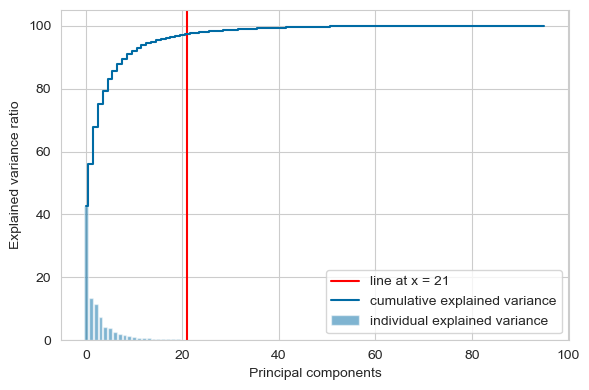

In [820]:
print(plt.style.available)
# Check the lengths of the arrays
print(len(var_exp), len(cum_var_exp))

# Trim or adjust arrays to match lengths for plotting
min_length = min(len(var_exp), len(cum_var_exp))
var_exp = var_exp[:min_length]  # Truncate var_exp to the minimum length
cum_var_exp = cum_var_exp[:min_length]  # Truncate cum_var_exp to the minimum length

# Proceed with the plot using the adjusted arrays
with plt.style.context('tableau-colorblind10'):
    plt.figure(figsize=(6, 4))
    plt.axvline(x=i, label='line at x = {}'.format(i), c='r')
    plt.bar(range(min_length), var_exp, alpha=0.5, align='center', label='individual explained variance')
    plt.step(range(min_length), cum_var_exp, where='mid', label='cumulative explained variance')

    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig(_path_1 + '/Fig1.png', format='png', dpi=1200)
    plt.show()
# with plt.style.context('classic'):
#     plt.figure(figsize=(6, 4))
#     plt.axvline(x=i, label='line at x = {}'.format(i), c='r')
#     plt.bar(range(len(table.columns)-1), var_exp, alpha=0.5, align='center',
#             label='individual explained variance')
#     plt.step(range(len(table.columns)-1), cum_var_exp, where='mid',
#              label='cumulative explained variance')
    
#     plt.ylabel('Explained variance ratio')
#     plt.xlabel('Principal components')
#     plt.legend(loc='best')
#     plt.tight_layout()
# plt.savefig(_path_1+'/Fig1.png', format='png', dpi=1200)
# plt.show()

In [821]:
labels = np.unique(y, axis=0)

In [822]:
labels

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

### Data distribution in relevant components

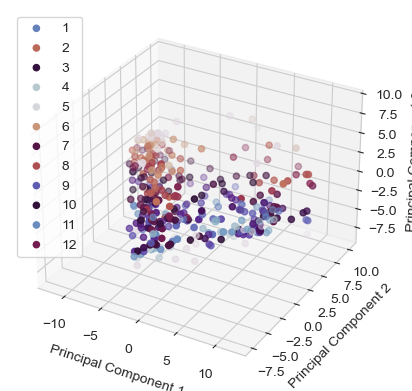

In [823]:
sklearn_pca = sklearnPCA(n_components=i)
Y_sklearn = sklearn_pca.fit_transform(X_std)

ax = plt.axes(projection='3d')
with plt.style.context('tableau-colorblind10'):
#     plt.figure(figsize=(8, 6))
    for lab in labels:
#         plt.scatter(Y_sklearn[y==lab, 0],
#                     Y_sklearn[y==lab, 1],
#                     label=lab)
        zdata = Y_sklearn[y==lab, 2]
        xdata = Y_sklearn[y==lab, 0]
        ydata = Y_sklearn[y==lab, 1]
        ax.scatter3D(xdata, ydata, zdata, c=zdata, label=lab, cmap='twilight');
#     plt.xlabel('Principal Component 1')
#     plt.ylabel('Principal Component 2')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.legend(loc="best")
#     plt.legend(loc='best')
#     plt.tight_layout()
    plt.savefig(_path_1+'/Fig2.png', format='png', dpi=1200)
    plt.show()

### Variance of each component

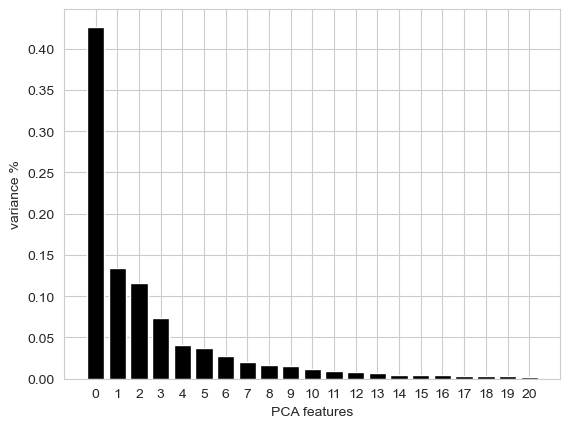

In [824]:
features = range(sklearn_pca.n_components_)
plt.bar(features, sklearn_pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.savefig(_path_1+'/Fig3.png', format='png', dpi=1200)
plt.show()

In [825]:
# Save components to a DataFrame
PCA_components = pd.DataFrame(Y_sklearn)

In [826]:
PCA_components.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,-7.542521,1.753963,-3.888172,-2.036019,-1.684302,2.353188,0.826862,1.588343,3.160844,-0.109319,...,-0.023769,0.353906,-0.314066,-0.063962,-0.516820,0.613711,0.196389,-0.246484,0.150159,-0.416182
1,-11.467156,5.804210,-0.503684,-1.726800,0.893621,0.466941,-0.367481,0.356191,-0.811350,-0.102717,...,0.123392,0.043629,0.303000,-0.112650,-0.435866,-0.133392,0.013073,0.176194,0.029643,-0.041580
2,-9.913104,3.265811,-2.641105,-1.474532,-2.408180,2.300207,0.086783,0.840233,-1.450870,-0.218109,...,-1.009700,-0.485545,-0.169035,0.046756,1.124598,-0.899003,0.927549,-0.396284,0.075910,-0.092836
3,-8.123633,0.821463,-6.106485,-0.385402,4.396654,0.942469,-0.828792,1.357117,-0.061728,-0.310216,...,0.122289,0.136717,0.491591,0.373157,-0.357231,-0.494356,0.772935,-0.642474,-0.021355,-0.114232
4,-10.285111,2.710104,-2.205701,-1.498664,-1.485944,1.826705,-0.203437,0.879543,-1.317105,-0.320816,...,-1.461244,-0.694639,-0.238236,0.111460,1.385347,-0.965936,1.688761,-0.842280,0.070237,0.143089


### Getting the optimal number of clusters

In [827]:
# ks = range(1, max_cluster)
# inertias = []
# for k in ks:
#     # Create a KMeans instance with k clusters: model
#     model = KMeans(n_clusters=k)
    
#     # Fit model to samples
#     model.fit(PCA_components.iloc[:,:i])
    
#     # Append the inertia to the list of inertias
#     inertias.append(model.inertia_)
    
# plt.plot(ks, inertias, '-o', color='black')
# plt.xlabel('number of clusters, k')
# plt.ylabel('inertia')
# plt.xticks(ks)
# plt.savefig(_path_1+'/Fig4.png', format='png', dpi=1200)
# plt.show()

In [828]:
# opt_cluster = 0
# for k in range(len(inertias)-1):
#     diff = abs(inertias[k]-inertias[k+1])/inertias[k]*100
#     if diff > 0.1:
#         opt_cluster += 1
#     else:
#         break
# print("Optimal number of clusters: ", opt_cluster)

In [829]:
# with plt.style.context('tableau-colorblind10'):
#     plt.figure(figsize=(6, 4))
#     plt.axvline(x=opt_cluster, label='Optimal number of clusters at k = {}'.format(opt_cluster), c='r')
#     # plt.bar(range(len(table.columns)-1), var_exp, alpha=0.5, align='center',
#             # label='individual explained variance')
#     plt.step(range(len(inertias)), inertias, where='mid',
#              label='cumulative inertia')
    
#     plt.ylabel('Inertia')
#     plt.xlabel('Number of clusters, k')
#     plt.legend(loc='best')
#     plt.tight_layout()
# plt.savefig(_path_1+'/Fig5.png', format='png', dpi=1200)
# plt.show()

### %opt_cluster Five clusters are chosen, so we run K-medoids with number of clusters equals four.
### Same initializer and random state as before

In [830]:
#%% Clustering method
print("Clustering")
if cluster_method == 0:
    KMeansMethod(opt_cluster, Y_sklearn, _path_0, _path_1, CaseName_Base, CaseName_ByStages, table, data)
elif cluster_method == 1:
    results = KMedoidsMethod(opt_cluster, Y_sklearn, _path_0, _path_1, CaseName_Base, CaseName_ByStages, table, ddf_1)
print('End of the process...')

Clustering


c:\Users\erik_\miniconda3\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:297: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


End of the process...
